# SARK-110 Time Domain and Gating Example

Example adapted from: https://scikit-rf.readthedocs.io/en/latest/examples/networktheory/Time%20Domain.html

- Measurements with a 2.8m section of rg58 coax cable not terminated at the end 

This notebooks demonstrates how to use scikit-rf for time-domain analysis and gating. A quick example is given first, followed by a more detailed explanation.

S-parameters are measured in the frequency domain, but can be analyzed in time domain if you like. In many cases, measurements are not made down to DC. This implies that the time-domain transform is not complete, but it can be very useful non-theless. A major application of time-domain analysis is to use gating to isolate a single response in space. More information about the details of time domain analysis.

Please ensure that the analyzer is connected to the computer using the USB cable and in Computer Control mode.

In [1]:
from sark110 import *
import skrf as rf 
rf.stylely()
from pylab import *

Enter frequency limits:

In [2]:
fr_start = 100000      # Frequency start in Hz
fr_stop =  230000000   # Frequency stop in Hz
points = 401           # Number of points

## Utility functions

In [3]:
def z2vswr(rs: float, xs: float, z0=50 + 0j) -> float:
    gamma = math.sqrt((rs - z0.real) ** 2 + xs ** 2) / math.sqrt((rs + z0.real) ** 2 + xs ** 2)
    if gamma > 0.980197824:
        return 99.999
    swr = (1 + gamma) / (1 - gamma)
    return swr


def z2mag(r: float, x: float) -> float:
    return math.sqrt(r ** 2 + x ** 2)


def z2gamma(rs: float, xs: float, z0=50 + 0j) -> complex:
    z = complex(rs, xs)
    return (z - z0) / (z + z0)

## Connect to the device

In [4]:
sark110 = Sark110()
sark110.open()
sark110.connect()
if not sark110.is_connected:
    print("Device not connected")
    exit(-1)
else:
    print("Device connected")

Device connected


In [5]:
sark110.buzzer()
print(sark110.fw_protocol, sark110.fw_version)

2566 1.5


## Acquire and plot the data

In [6]:
y = []
x = []
rs = [0]
xs = [0]
for i in range(points):
    fr = int(fr_start + i * (fr_stop - fr_start) / (points - 1))
    sark110.measure(fr, rs, xs)
    x.append(fr / 1e9)  # Units in GHz
    y.append(z2gamma(rs[0][0], xs[0][0]))

probe = rf.Network(frequency=x, s=y, z0=50)
probe.frequency.unit = 'mhz'
print (probe)

1-Port Network: '',  0.1-230.0 MHz, 401 pts, z0=[50.+0.j]


# Quick example

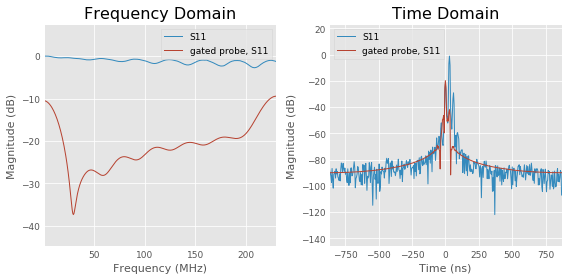

In [7]:
# we will focus on s11
s11 = probe.s11

#  time-gate the first largest reflection
s11_gated = s11.time_gate(center=0, span=50)
s11_gated.name='gated probe'

# plot frequency and time-domain s-parameters
figure(figsize=(8,4))
subplot(121)
s11.plot_s_db()
s11_gated.plot_s_db()
title('Frequency Domain')

subplot(122)
s11.plot_s_db_time()
s11_gated.plot_s_db_time()
title('Time Domain')
tight_layout()

# Interpreting Time Domain

Note there are two time-domain plotting functions in scikit-rf:

- Network.plot_s_db_time()
- Network.plot_s_time_db()

The difference is that the former, plot_s_db_time(), employs windowing before plotting to enhance impluse resolution. Windowing will be discussed in a bit, but for now we just use plot_s_db_time().

Plotting all four s-parameters of the probe in both frequency and time-domain.

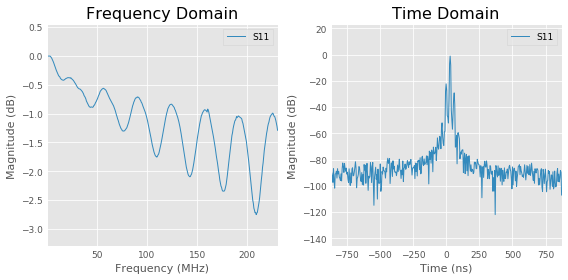

In [8]:
# plot frequency and time-domain s-parameters
figure(figsize=(8,4))
subplot(121)
probe.plot_s_db()
title('Frequency Domain')
subplot(122)
probe.plot_s_db_time()
title('Time Domain')
tight_layout()

Focusing on the reflection coefficient from the waveguide port (s11), you can see there is an interference pattern present.

Text(0.5, 1, 'Reflection Coefficient From \nWaveguide Port')

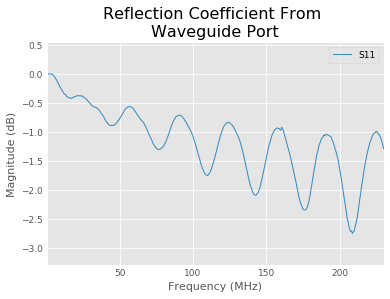

In [9]:
probe.plot_s_db(0,0)
title('Reflection Coefficient From \nWaveguide Port')

This ripple is evidence of several discrete reflections. Plotting s11 in the time-domain allows us to see where, or when, these reflections occur.

(-100, 0)

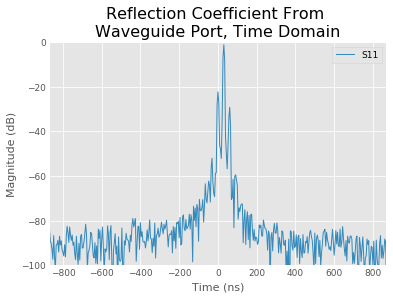

In [10]:
probe_s11 = probe.s11
probe_s11.plot_s_db_time(0,0)
title('Reflection Coefficient From \nWaveguide Port, Time Domain')
ylim(-100,0)

# Gating The Reflection of Interest
To isolate the reflection from the waveguide port, we can use time-gating. This can be done by using the method Network.time_gate(), and provide it an appropriate center and span (in ns). To see the effects of the gate, both the original and gated reponse are compared.

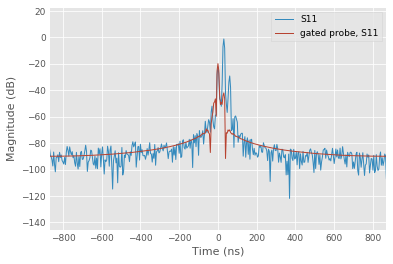

In [11]:
probe_s11_gated = probe_s11.time_gate(center=0, span=50)
probe_s11_gated.name='gated probe'

s11.plot_s_db_time()
s11_gated.plot_s_db_time()

Next, compare both responses in frequency domain to see the effect of the gate.

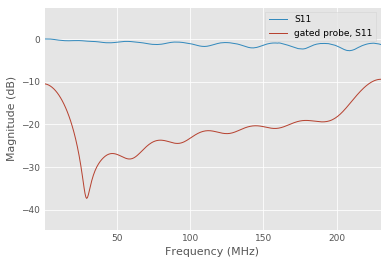

In [12]:
s11.plot_s_db()
s11_gated.plot_s_db()

# Auto-gate

The time-gating method in skrf has an auto-gating feature which can also be used to gate the largest reflection. When no gate parameters are provided, time_gate() does the following:

    find the two largest peaks
    center the gate on the tallest peak
    set span to distance between two tallest peaks

You may want to plot the gated network in time-domain to see what the determined gate shape looks like.

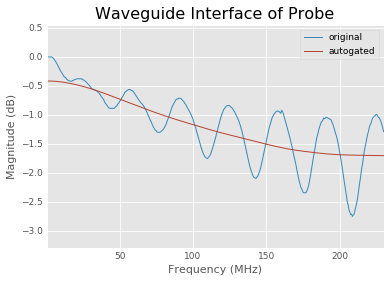

In [13]:
title('Waveguide Interface of Probe') 
s11.plot_s_db(label='original')
s11.time_gate().plot_s_db(label='autogated') #autogate on the fly

# Determining Distance

To make time-domain useful as a diagnostic tool, one would like to convert the x-axis to distance. This requires knowledge of the propagation velocity in the device. skrf provides some transmission-line models in the module skrf.media, which can be used for this.

However...

For dispersive media, such as rectangular waveguide, the phase velocity is a function of frequency, and transforming time to distance is not straightforward. As an approximation, you can normalize the x-axis to the speed of light.

Alternatively, you can simulate the a known device and compare the two time domain responses. This allows you to attribute quantatative meaning to the axes. For example, you could create an ideal delayed load as shown below. Note: the magnitude of a response behind a large impulse doesn not have meaningful units.


(-500, 500)

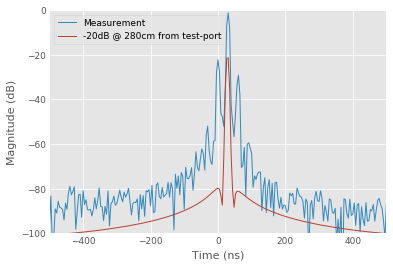

In [14]:
from skrf.media import DistributedCircuit

# create a Media object for RG-58, based on distributed ckt values
rg58 = DistributedCircuit(
    frequency = probe.frequency,
    C =93.5e-12,#F/m
    L =273e-9,  #H/m
    R =0,       #53e-3,   #Ohm/m
    G =0,       #S/m
    )

# create an ideal delayed load, parameters are adjusted until the
# theoretical response agrees with the measurement
theory = rg58.delay_load(Gamma0=rf.db_2_mag(-20),
                          d=280, unit='cm')
probe.plot_s_db_time(0,0, label = 'Measurement')
theory.plot_s_db_time(label='-20dB @ 280cm from test-port')
ylim(-100,0)
xlim(-500,500)

This plot demonstrates a few important points:

    the theortical delayed load is not a perfect impulse in time. This is due to the dispersion in waveguide.
    the peak of the magnitude in time domain is not identical to that specified, also due to disperison (and windowing).

# What the hell is Windowing?

The 'plot_s_db_time()' function does a few things.

    windows the s-parameters.
    converts to time domain
    takes magnitude component, convert to dB
    calculates time-axis s
    plots

A word about step 1: windowing. A FFT represents a signal with a basis of periodic signals (sinusoids). If your frequency response is not periodic, which in general it isnt, taking a FFT will introduces artifacts in the time-domain results. To minimize these effects, the frequency response is windowed. This makes the frequency response more periodic by tapering off the band-edges.

Windowing is just applied to improve the plot appearance,d it does not affect the original network.

In skrf this can be done explicitly using the 'windowed()' function. By default this function uses the hamming window, but can be adjusted through arguments. The result of windowing is show below.


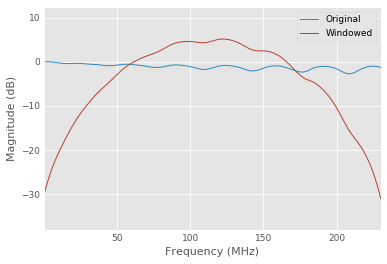

In [15]:
probe_w = probe.windowed()
probe.plot_s_db(0,0, label = 'Original')
probe_w.plot_s_db(0,0, label = 'Windowed')

Comparing the two time-domain plotting functions, we can see the difference between windowed and not.

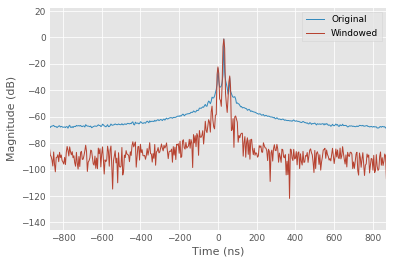

In [16]:
probe.plot_s_time_db(0,0, label = 'Original')
probe_w.plot_s_time_db(0,0, label = 'Windowed')

# The end!

In [17]:
sark110.close()